# Inference Data Mount

In [17]:
!sudo mount -t nfs4 -o nfsvers=4.1,rsize=1048576,wsize=1048576,hard,timeo=600,retrans=2,noresvport 172.31.91.151:/ ./efs_inference_data

Password:


# For Docker Run / Sagemaker

In [3]:
!pip install rasterio geopandas shapely tensorflow-addons[tensorflow]

zsh:1: no matches found: tensorflow-addons[tensorflow]


# Start Local / Sagemaker Imports

In [1]:
import os
import rasterio as rio
import numpy as np
from rasterio.windows import Window
from glob import glob
from shapely.geometry import Polygon
from shapely.geometry import box
import geopandas as gpd
from rasterio.windows import get_data_window
import rasterio as rio
from inference_predict import *

# Windowing

In [2]:
def get_windows(img_dim, patch_size=(240, 240), stride=(240, 240)):
    patch_size = np.array(patch_size)
    stride = np.array(stride)
    img_dim = np.array(img_dim)
    # to take into account edges, add additional blocks around right side edge and bottom edge of raster
    new_img_dim = [img_dim[0] + stride[0],img_dim[1] + stride[0]]
    
    max_dim = (new_img_dim//patch_size)*patch_size - patch_size

    ys = np.arange(0, img_dim[0], stride[0])
    xs = np.arange(0, img_dim[1], stride[1])

    tlc = np.array(np.meshgrid(ys, xs)).T.reshape(-1, 2)
    tlc = tlc[tlc[:, 0] <= max_dim[0]]
    tlc = tlc[tlc[:, 1] <= max_dim[1]]
    
    windows = []
    for y,x in tlc.astype(int):
        windows.append(Window(x, y, patch_size[1], patch_size[0]))

    return windows

In [3]:
def add_ndvi(data, dtype_1=rio.float32):
    
    nir = data[3].astype(dtype_1)
    red = data[0].astype(dtype_1)

    # Allow division by zero
    np.seterr(divide='ignore', invalid='ignore')

    # Calculate NDVI
    ndvi = np.zeros(nir.shape, dtype=dtype_1)
    ndvi = ((nir - red) / (nir + red)).astype(dtype_1)

    # Rescaling for use in 16bit output

    ndvi = (ndvi + 1) * (2**15 - 1)

    # Add NDVI band to end of array    
    rast = np.concatenate((data,[ndvi]),axis=0)
    
    rast = rast.astype(rio.uint16)
    
    return rast


# Download Model Files

In [4]:
# model_url = "s3://canopy-production-ml/inference/model_files/model-best.h5"
# weights_url = "s3://canopy-production-ml/inference/model_files/model_weights_best.h5"

# download_model(model_url,weights_url)

In [5]:
model = load_model("model.h5","model_weights.h5") 

In [6]:
label_list = ["Industrial_agriculture","ISL","Mining","Roads","Shifting_cultivation"]

In [43]:
def output_windows(granule_dir,patch_size=100,
                   stride=100,SAVE=False,SAVE_INDIVIDUAL=False,
                   bands=[2, 3, 4, 8, 11, 12], 
                  model=model,
                   predict_thresh=.5,
                  label_list=label_list, 
                  job_name="test_inference", 
                  output_filename="./inference_output/result.json"):
    
    granule_list = glob(f'{granule_dir}/*.tif')
    
    output_dict = {}
    
    granule_id_list = []
    
    window_id_list = []
    
    window_geom_list = []
    
    data_list = []
    
    label_master_list = []
    
    gdf_list = []
    
    timestamp = gen_timestamp()
    
    for j,granule_path in enumerate(granule_list):
        
        granule_id = granule_path.split("/")[-1].split("_")[0]
    
        with rio.open(granule_path) as src:

            windows = get_windows(src.shape, (patch_size, patch_size), (stride, stride))

            for i, window in enumerate(windows):
                
                print(f"predicting window {i + 1} of {len(windows)} of granulate {j + 1} of {len(granule_list)}",end='\r', flush=True)
                
                label_name_list = []
                
                window_id = i+1

#                 granule_id_list.append(granule_id)

#                 window_id_list.append(window_id)

                #need to understand impact of "masked" argument for inference

                data = src.read(bands,window=window, masked=True)

                data = add_ndvi(data)
        
                shape = data.shape
            
                new_shape = (data.shape[0],patch_size,patch_size)
            
                if shape != new_shape:

                    filled_array = np.full(new_shape, 0)
                    filled_array[:shape[0],:shape[1],:shape[2]] = data
                    data = filled_array
                    window = Window(window.col_off,window.row_off,shape[2],shape[1])
                    
                    
                #image pre-processing / inference
                prediction = model.predict(read_image_tf_out(data))
                prediction = np.where(prediction > predict_thresh, 1, 0)
                prediction_i = np.where(prediction == 1)[1]
                for i in prediction_i:
                    label_name_list.append(label_list[i])
                
                label_master_list.append(label_name_list)
                
                #vectorizing raster bounds for visualization 
                window_bounds = rio.windows.bounds(window, src.transform, height=patch_size, width=patch_size)
                geom = box(*window_bounds)
                geom_coords = list(geom.exterior.coords)
#                 window_geom_list.append(geom)
                
                #create or append to dict....
                
                if granule_id in output_dict:

                    output_dict[granule_id].append({"window_id":window_id,"polygon_coords":geom_coords,"labels":label_name_list})


                else:

                    output_dict[granule_id] = [{"window_id":window_id,"polygon_coords":geom_coords,"labels":label_name_list}]
        
        save_to_s3(output_dict,output_filename,job_name,timestamp)
        


#             gdf = gpd.GeoDataFrame({"granule_id":granule_id_list,"window_id":window_id_list,"geometry":window_geom_list,"labels":label_master_list})
#             gdf["labels"] = gdf["labels"].astype(str)

#             gdf_list.append(gdf)
            
    return output_dict


    #             if SAVE:

    #                 if SAVE_INDIVIDUAL:
    #                     meta = raster.meta.copy()
    #                     # Get the window specific transform - IF we want to save windows independantly
    #             #         trans = raster.window_transform(window)
    #                     meta.update({
    #             #                 'transform': trans,
    #                             'dtype': src.dtype
    #                         })

    #                     with rasterio.open(f"{out_path}/some_chip_{j}.tif", 'w', **meta) as dest:
    #                         dest.write(data)
    #                 else:
    #                     meta = raster.meta.copy()

    #                     with rasterio.open(f"{out_path}/some_chip_{j}.tif", 'w+', **meta) as dest:
    #                         dest.write(data, window=window)

In [ ]:
# granule_dir = "./efs_inference_data/"
granule_dir = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/Inference_Test"

output_dict = output_windows(granule_dir)

In [30]:
list(output_dict.exterior.coords)

[(17.279094490038997, -3.718486287084347),
 (17.279094490038997, -3.709503134243152),
 (17.2701113371978, -3.709503134243152),
 (17.2701113371978, -3.718486287084347),
 (17.279094490038997, -3.718486287084347)]

In [15]:
new_gdf.shape

(358780, 4)

<AxesSubplot:>

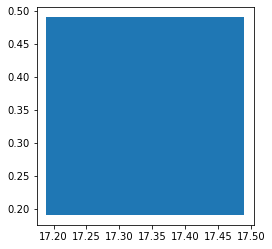

In [8]:
gdf.plot()

In [16]:
new_gdf.to_file("./inference_output/test.geojson", driver='GeoJSON')

In [20]:
gdf.to_file("./inference_output/test.geojson", driver='GeoJSON')

# Staging

In [58]:
import time

In [12]:

d = {}

In [13]:
save_to_s3(d,"result.json","test_output",gen_timestamp())

'2021-04-27-05-08-01'